In [1]:
# autoreload for utils.py edits
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

# helper library
from utils import (
    register_hooks,
    remove_hooks,
    run_and_cache,
    patch_activations,
    compute_metrics,
    plot_patching_results
)

from aeon.datasets import load_classification
from TSTtrainer import TimeSeriesTransformer

## Loading and preprocessing JapaneseVowels data

In [2]:
X_train, y_train = load_classification("JapaneseVowels", split="train")
X_test, y_test = load_classification("JapaneseVowels", split="test")

# swap axes to (N, seq_len, 1) and convert to float32
def prep(X):
    X_np = X.astype(np.float32)
    return np.swapaxes(X_np, 1, 2)

X_test = torch.tensor(prep(X_test))
y_test = torch.tensor(y_test.astype(np.int64))

print("Test set:", X_test.shape, y_test.shape)

Test set: torch.Size([370, 25, 12]) torch.Size([370])


## Instantiate trained TST model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = X_test.shape[1]
input_dim = X_test.shape[2]
num_classes = y_test.max() + 1

model = TimeSeriesTransformer(
    input_dim=input_dim,
    num_classes=num_classes,
    seq_len=seq_len,
    d_model=128,
    n_head=8,
    num_encoder_layers=3,
    dim_feedforward=256,
    dropout=0.1
).to(device)

# LOAD CHECKPOINT
model.load_state_dict(torch.load("TST_japanesevowels.pth", map_location=device, weights_only=True))

<All keys matched successfully>

## Pick two test-set instances and examine

In [5]:
idx_1 = 32
idx_2 = 36

x1 = X_test[[idx_1]].to(device)
y1 = y_test[[idx_1]].item()

x2 = X_test[[idx_2]].to(device)
y2 = y_test[[idx_2]].item()

print(f"Instance {idx_1} label={y1}, Instance {idx_2} label={y2}")

Instance 32 label=2, Instance 36 label=2


# Plot the raw time-series for each instance

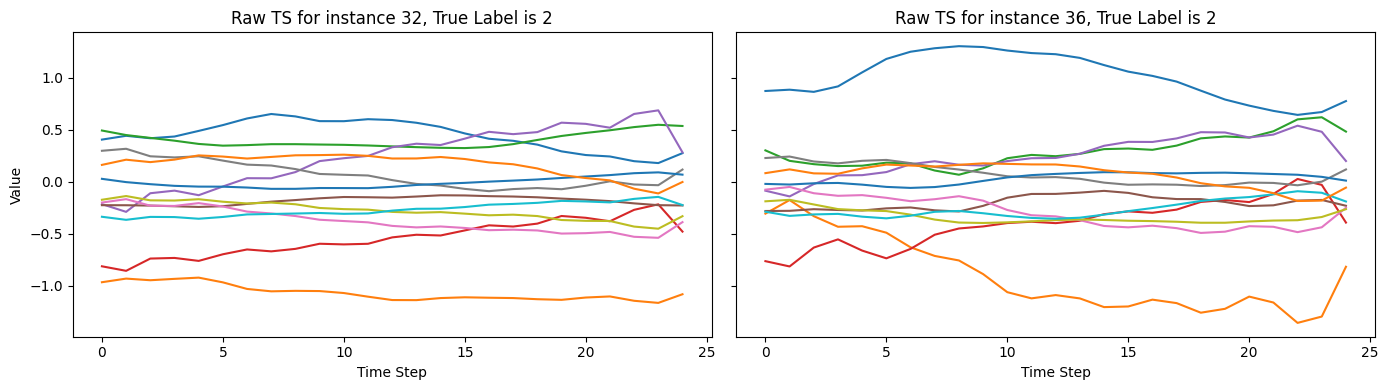

In [9]:
series_idx_1 = x1.cpu().numpy().squeeze()
series_idx_2 = x2.cpu().numpy().squeeze()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)

axes[0].plot(x1.squeeze().cpu().numpy())
axes[0].set_title(f"Raw TS for instance {idx_1}, True Label is {y1}")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")

axes[1].plot(x2.squeeze().cpu().numpy())
axes[1].set_title(f"Raw TS for instance {idx_2}, True Label is {y2}")
axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

# Patching Experiment: ATTENTION HEAD PATCHING, LAYER-BY-LAYER

In [14]:
layers_to_patch = [
    "transformer_encoder.layers.0.self_attn",
    "transformer_encoder.layers.1.self_attn",
    "transformer_encoder.layers.2.self_attn"
]

patching_results = []

for layer_name in layers_to_patch:
    print(f"-- Patching {layer_name} --")
    
    # cache idx_1 activations
    cache_idx1 = run_and_cache(model, x1, hook_layers=[layer_name])
    
    # patch into idx_2 input
    logits_patched = patch_activations(model, x2, cache_idx1, hook_layers=[layer_name])
    
    # metrics
    logits_idx2 = model(x2)
    metrics = compute_metrics(logits_idx2, logits_patched, labels=torch.tensor([y2]))
    metrics['layer'] = layer_name
    patching_results.append(metrics)
    
plot_patching_results(patching_results, metric='acc_drop')

-- Patching transformer_encoder.layers.0.self_attn --


AttributeError: 'TimeSeriesTransformer' object has no attribute 'transformer_encoder'